In [1]:
# What version python do you have 
#import tensorflow.keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

check_gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE" )

GPU is available


In [2]:
#tipos de datos 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)   #establece el tipo de float predeterminado

In [26]:
x_1 = tf.constant( 0  ,shape = (1,1), dtype = DTYPE )
X_data = [x_1]

u_data_1 = tf.constant( 1  ,shape = (1,1), dtype = DTYPE )
u_data_2 = tf.constant( 0  ,shape = (1,1), dtype = DTYPE )

u_data = [u_data_1, u_data_2]

In [27]:
#Numero de Puntos
N_r = 200

#Dominio 1
xmin = 0
xmax = 10


#Dibujo de un muestreo uniforme de los puntos de colocación
X_r = tf.random.uniform((N_r,1), xmin, xmax, dtype = DTYPE)

In [28]:
def fun_0( x, y_1, y_2, dy_1_dx, dy_2_dx):
    #y = np.expand_dims(y, axis = -1)
   
    return dy_1_dx - y_2  , dy_2_dx + tf.math.sin(y_1)


In [29]:
#Configuración Red Neuronal
def init_model(num_hidden_layers = 2, num_neurons_per_layer = 20 ):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(1))
    
    # Introduce a scaling layer to map input to [lb, ub]
    #scaling_layer = tf.keras.layers.Lambda(
    #            lambda x: 2.0*(x - 0)/(10 - 0) - 1.0)
    #model.add(scaling_layer)
    
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, 
                                        activation = tf.keras.activations.get('sigmoid'),
                                       kernel_initializer = 'glorot_normal'))
    model.add(tf.keras.layers.Dense(2))
    
    return model

In [30]:
#model = init_model()
#x = X_r

In [31]:
#model(x)[:,0:1]

In [32]:
def get_r(model , X_r): 
    x = X_r
       
    with tf.GradientTape(persistent = True) as tape:         
        tape.watch(x)
        y_1 = model(x)[:,0:1]
        y_2 = model(x)[:,1:2]
    dy_1_dx = tape.gradient(y_1,x)
    dy_2_dx = tape.gradient(y_2,x)
    
    
    #del tape
    
    
    return fun_0( x, y_1, y_2, dy_1_dx, dy_2_dx)
        
    #return fun_0(x, y, dy_dx) 

In [33]:
def compute_loss(model , X_r, X_data, u_data):
    
    # Compute phi^r
    r_1, r_2 = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r_1)) + tf.reduce_mean(tf.square(r_2))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    u_pred1 = model(X_data[0])[:,0:1]
    loss += tf.reduce_mean(tf.square(u_data[0] - u_pred1))
    
    u_pred2 = model(X_data[0])[:,1:2]
    loss += tf.reduce_mean(tf.square(u_data[1] - u_pred2)) 
    
    return loss

In [38]:
#Calculo de gradientes de la función de pérdida

#def get_grad(model, X_r, X_data, u_data):
def get_grad(model, X_r, X_data, u_data):
    with tf.GradientTape(persistent = True) as tape: 
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)
        #loss = compute_loss(model, X_r, X_data, u_data)
        
    g = tape.gradient(loss, model.trainable_variables)    
    #del tape
    
    return loss, g

In [39]:
# Initialize model aka u_\theta
model = init_model()



# Choose the optimizer
optim = tf.keras.optimizers.Adam(0.01)

In [43]:
from time import time 

#@tf.function 
def train_step():
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    #loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    #Realizar paso del descenso de gradiente
    optim.apply_gradients(zip(grad_theta, model.trainable_variables ))
    
    return loss

#Número de Épocas
N = 4000
hist = []

#Comienzo del tiempo
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    hist.append(loss.numpy())
    
    #Salida después de 50 iteraciones
    if i%1000 == 0:
        print('It {:05d}: loss = {:10.8e}'. format(i,loss))
        
#Mostrar tiempo de calculo 
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 5.38788037e-03
It 01000: loss = 3.01445252e-03
It 02000: loss = 1.01063144e-03
It 03000: loss = 3.12469841e-04
It 04000: loss = 2.64651317e-04

Computation time: 53.46463632583618 seconds


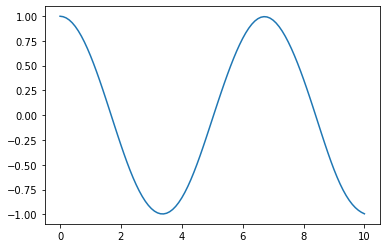

In [46]:
# Gráfica

N = 100
xspace = np.linspace(xmin, xmax, N + 1)
x_test = tf.constant(xspace, shape = (N+1,1) , dtype
                     = DTYPE)
plt.plot(x_test, model(x_test)[:,0:1])
#plt.axis([0,10,0.9995,1.0005])